In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import duckdb # -> Thư viện "giả lập" xử lý dữ liệu bằng SQL 
from datetime import date
from datetime import time
from sklearn.cluster import KMeans

In [2]:
order_detail_df = pd.read_excel("data/order.xlsx", parse_dates = ['Ngày phát sinh'])
user_df = pd.read_excel("data/user.xlsx", parse_dates = ['Ngày đăng ký tài khoản'])
listening_detail_df = pd.read_excel("data/listening.xlsx")

#### Chuyển kiểu dữ liệu

In [3]:
# Chuyển User_ID và Order_ID sang category
order_detail_df['Order ID'] = order_detail_df['Order ID'].astype('category')
order_detail_df['ID của user'] = order_detail_df['ID của user'].astype('category')

user_df['User ID'] = user_df['User ID'].astype('category')

listening_detail_df['Playlist ID']=listening_detail_df['Playlist ID'].astype('category')
listening_detail_df['User ID']=listening_detail_df['User ID'].astype('category')

In [4]:
# Chuyển Ngày phát sinh lượt nghe sang kiểu dữ liệu date
listening_detail_df["Ngày phát sinh lượt nghe"] = listening_detail_df["Ngày phát sinh lượt nghe"].map(
                                        lambda x:date(int(x.split("-")[2]),int(x.split("-")[1]),int(x.split("-")[0])))

In [5]:
listening_detail_df["Ngày phát sinh lượt nghe"] = listening_detail_df["Ngày phát sinh lượt nghe"].astype("datetime64")

In [6]:
order_detail_df.head(3)

,Order ID,Ngày phát sinh,ID của user,Loại hoá đơn (9k/Xu/VIP),Giá trị hoá đơn
0,6706,2020-08-16,44822,VIP,199000
1,6998,2020-08-23,47128,VIP,199000
2,6927,2020-08-21,47134,VIP,199000


In [7]:
user_df.head(3)

,User ID,VIP hay Free,Giới tính,Năm sinh,Việt Nam hay Nước ngoài,iOS hay Android,Ngày đăng ký tài khoản,Tổng số lượt nghe,Tổng thời lượng nghe (phút)
0,86229,free,male,NaN,VN,android,2020-11-27,218,4151.3
1,48053,free,male,1995.0,VN,ios,2020-08-24,19,278.6
2,46340,free,male,1988.0,VN,website,2020-08-19,28,170.5


In [8]:
listening_detail_df.head(3)

,Playlist ID,Tên playlist,Category tầng 1 của playlist,Category tầng 2 của playlist,Playlist là Free hay VIP,Thời lượng của playlist (phút),Thời lượng của lượt nghe (phút),User ID,Giờ phát sinh lượt nghe,Ngày phát sinh lượt nghe
0,4529,Dạy Tiếng Anh Cho Trẻ Mầm Non,Podcast,Học ngoại ngữ,free,44.9,0.1,82846,06:05,2020-12-03
1,4577,Tư Duy Tích Cực - Bạn Là Những Gì Bạn Nghĩ (Nh...,Sách nói,Hạnh phúc,vip,79.8,15.9,56112,12:49,2020-10-30
2,4169,50 thiên thần của bạn: Giải phóng bản thân khỏ...,Sách nói,Tâm linh,vip,324.8,6.8,94362,00:17,2020-12-15


In [68]:
# listening_detail_df.to_csv("data/pre_listening.csv")

In [9]:
# listening_detail_df.describe(include = 'all')

In [10]:
# order_detail_df.describe(include = 'all')

In [11]:
# user_df.describe(include = 'all')

#### Khảo sát về sự consistence của các USER_ID trong các file

In [13]:
order_userID = order_detail_df['ID của user'].unique()
userID = user_df['User ID'].unique()
listen_userID = listening_detail_df['User ID'].unique()

un_ordered_user = [item for item in userID if item not in order_userID]
ordered_ex_user = [item for item in order_userID if item not in userID]

listen_not_in_user = [item for item in listen_userID if item not in userID]
order_not_in_listen_user = [item for item in order_userID if item  not in listen_userID]
listen_not_in_order_user = [item for item in listen_userID if item  not in order_userID]

print("số lượng user trong hệ thống và những user đã order:")
print(str(userID.shape[0]) +', '+str(order_userID.shape[0]))
print("số lượng user đã Không order và những user đã order mà không có trong danh sách:")
print(str(len(un_ordered_user)) +', '+str(len(ordered_ex_user)))
print("số lượng user đã listen và nhưng không có trong danh sách:" +str(len(listen_not_in_user)))
print("số lượng user đã order nhưng không listen:" +str(len(order_not_in_listen_user)))
print("số lượng user đã listen nhưng không order:" +str(len(listen_not_in_order_user)))

số lượng user trong hệ thống và những user đã order:
66146, 2638
số lượng user đã Không order và những user đã order mà không có trong danh sách:
63508, 0
số lượng user đã listen và nhưng không có trong danh sách:0
số lượng user đã order nhưng không listen:275
số lượng user đã listen nhưng không order:24820


##### Xem những người có order mà ko listen hay mua gì

In [15]:
listen_not_in_order_user_df = order_detail_df[~order_detail_df['ID của user'].isin(listening_detail_df['User ID'])]
listen_not_in_order_user_df.describe(include = 'all')

<ipython-input-15-bf11b086a8e0>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  listen_not_in_order_user_df.describe(include = 'all')


,Order ID,Ngày phát sinh,ID của user,Loại hoá đơn (9k/Xu/VIP),Giá trị hoá đơn
count,330.0,330,330.0,330,330.000000
unique,328.0,119,275.0,3,NaN
top,1387.0,2020-12-29 00:00:00,94352.0,9K,NaN
freq,2.0,12,6.0,118,NaN
first,NaN,2020-07-17 00:00:00,NaN,NaN,NaN
last,NaN,2020-12-31 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,148703.030303
std,NaN,NaN,NaN,NaN,186912.661829
min,NaN,NaN,NaN,NaN,9000.000000
25%,NaN,NaN,NaN,NaN,9000.000000


In [16]:
listen_not_in_order_user_df["Loại hoá đơn (9k/Xu/VIP)"].value_counts()

9K     118
VIP    115
XU      97
Name: Loại hoá đơn (9k/Xu/VIP), dtype: int64

## Xét ORDERs

In [17]:
order_detail_df.head(3)

,Order ID,Ngày phát sinh,ID của user,Loại hoá đơn (9k/Xu/VIP),Giá trị hoá đơn
0,6706,2020-08-16,44822,VIP,199000
1,6998,2020-08-23,47128,VIP,199000
2,6927,2020-08-21,47134,VIP,199000


In [19]:
##### Cắt nhỏ giá trị order_date

order_detail_df['order_year'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%Y'))
order_detail_df['order_month'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%m'))
order_detail_df['order_day'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%d'))
order_detail_df['order_weekday'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%A'))
order_detail_df.head(3)

,Order ID,Ngày phát sinh,ID của user,Loại hoá đơn (9k/Xu/VIP),Giá trị hoá đơn,order_year,order_month,order_day,order_weekday
0,6706,2020-08-16,44822,VIP,199000,2020,08,16,Sunday
1,6998,2020-08-23,47128,VIP,199000,2020,08,23,Sunday
2,6927,2020-08-21,47134,VIP,199000,2020,08,21,Friday


## Xét Listenings

In [20]:
listening_detail_df.head(3)

,Playlist ID,Tên playlist,Category tầng 1 của playlist,Category tầng 2 của playlist,Playlist là Free hay VIP,Thời lượng của playlist (phút),Thời lượng của lượt nghe (phút),User ID,Giờ phát sinh lượt nghe,Ngày phát sinh lượt nghe
0,4529,Dạy Tiếng Anh Cho Trẻ Mầm Non,Podcast,Học ngoại ngữ,free,44.9,0.1,82846,06:05,2020-12-03
1,4577,Tư Duy Tích Cực - Bạn Là Những Gì Bạn Nghĩ (Nh...,Sách nói,Hạnh phúc,vip,79.8,15.9,56112,12:49,2020-10-30
2,4169,50 thiên thần của bạn: Giải phóng bản thân khỏ...,Sách nói,Tâm linh,vip,324.8,6.8,94362,00:17,2020-12-15


# CLUSTERING

In [ ]:
## Ta đi từ bảng listenning và bảng order
## Có 2 clustering DFM và RFM
## D1: The listening duration / 1 listen(view)
## D2: The listening duration / a week
## R: The lastest active day

## F: số lượng lượt nghe/1 week
## M : số tiền bỏ ra / 1 week

In [64]:
# for Ebowl
def find_sse(df, max_k):
    sse = {}
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, max_iter=1000)
        kmeans.fit(df)
        df['clusters'] = kmeans.labels_
        sse[k] = kmeans.inertia_
    return sse
   
## function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

## PRE_PROCESS data

In [121]:
order_summary_df = order_detail_df.groupby('ID của user').agg(
                    {'Ngày phát sinh': ['min', 'max', 'count'],
                     'Giá trị hoá đơn': 'sum',
                    }
                    ).reset_index()
order_summary_df.columns = ['User_ID','min_purchase_date','max_purchase_date','order_cnt','revenue']

order_summary_df.head(3)

,User_ID,min_purchase_date,max_purchase_date,order_cnt,revenue
0,40843,2020-09-15,2020-10-21,3,27000
1,40861,2020-09-09,2020-09-09,1,199000
2,41003,2020-10-27,2020-10-27,1,599000


In [122]:
listening_summary_df = listening_detail_df.groupby('User ID').agg(
                    {"Ngày phát sinh lượt nghe":['min','max'],
                     "Thời lượng của lượt nghe (phút)":['count','sum']
                    }
                ).reset_index()
listening_summary_df.columns = ['User_ID','first_listen_date','last_listen_date','listen_cnt','total_listen_minute']
listening_summary_df.head(3)

,User_ID,first_listen_date,last_listen_date,listen_cnt,total_listen_minute
0,40834,2020-07-08,2020-07-08,2,8.7
1,40835,2020-09-02,2020-10-07,5,68.8
2,40839,2020-07-21,2020-10-11,60,1104.5


In [89]:
# user_clustering_df = pd.concat(objs=[order_summary_df['User_ID'],listening_summary_df['User_ID']],axis=0,join='outer')

## DFM CLUSTERING (duration - frequency - monetary)

In [207]:
# Lấy user_id từ 2 bảng order và listening gộp vào 1 bảng
dfm_user_df = pd.DataFrame(pd.concat(objs=[listening_summary_df['User_ID'],order_summary_df['User_ID']]).drop_duplicates().reset_index(drop=True))
dfm_user_df.columns = ["User_ID"]
dfm_user_df.head(3)

,User_ID
0,40834
1,40844
2,40847


### Duration:  The avg listening duration / 1 listen(view)

#### 1.CALCULATE  the average duration of a listening

In [44]:
print("số user có tổng thời gian nghe là 0: "+str(listening_summary_df[listening_summary_df['total_listen_minute']==0.0].shape[0]))
print("số user có tổng lượt nghe là 0: "+ str(listening_summary_df[listening_summary_df['listen_cnt']==0.0].shape[0]))

số user có tổng thời gian nghe là 0: 93
số user có tổng lượt nghe là 0: 0


In [124]:
# Duration: listen_minute per week: thời lượng nghe trung bình của 1 lượt nghe (tính theo đơn vị phút)
listening_summary_df["DFM_Duration_per_view"] = listening_summary_df['total_listen_minute']/listening_summary_df["listen_cnt"]

In [49]:
listening_summary_df["DFM_Duration_per_view"].describe()

count    27183.000000
mean        10.287329
std         14.468284
min          0.000000
25%          1.733333
50%          6.330328
75%         13.833333
max        535.300000
Name: DRM_Duration_per_view, dtype: float64

<AxesSubplot:xlabel='DRM_Duration_per_view', ylabel='Count'>

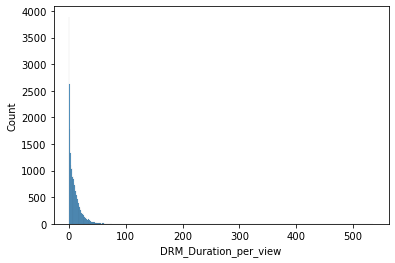

In [50]:
sns.histplot(data=listening_summary_df,x='DFM_Duration_per_view')

#### 2. Determine K

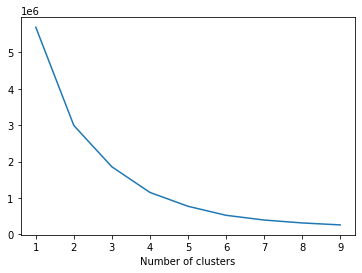

In [65]:
# ## Elbow Method to determine K

# sse = find_sse(listening_summary_df.loc[:,['DFM_Duration_per_view']], max_k = 10) 

# plt.figure()
# plt.plot(list(sse.keys()),list(sse.values()))
# plt.xlabel("Number of clusters")
# plt.show() 

# # Optimal K=5
# ## Choose the k of Recency_clusters = 3
# ## 1st: 'active', 2st: 'sleep', 3rd: 'hibernate'

#### 3. Duration Clustering

In [126]:
# ## k-means = 5
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(listening_summary_df[['DFM_Duration_per_view']])
# listening_summary_df['DFM_DurationCluster'] = kmeans.predict(listening_summary_df[['DFM_Duration_per_view']])

# listening_summary_df = order_cluster('DFM_DurationCluster', 'DFM_Duration_per_view',listening_summary_df,True)
# listening_summary_df.groupby('DFM_DurationCluster')['DFM_Duration_per_view'].describe()

# ## see details of each cluster - Thời lượng (phút) của 1 lượt nghe

,count,mean,std,min,25%,50%,75%,max
DFM_DurationCluster,,,,,,,,
0,17148.0,3.451987,2.855969,0.000000,0.900000,2.580000,5.689708,9.747619
1,7973.0,16.073797,4.713608,9.750000,12.083721,15.055556,19.408333,27.354839
2,1897.0,38.723402,9.989065,27.358333,30.716783,35.540816,44.336364,69.500000
3,157.0,101.144128,33.676878,70.040000,75.842857,87.500000,115.100000,211.821739
4,8.0,368.937553,106.769120,245.500000,298.620833,324.405556,436.571154,535.300000


### Frequency - the average number of listening per week

#### 1.CALCULATE Frequency

In [127]:
listening_summary_df.head(3)

,User_ID,first_listen_date,last_listen_date,listen_cnt,total_listen_minute,DFM_Duration_per_view,DFM_DurationCluster
0,40834,2020-07-08,2020-07-08,2,8.7,4.350000,0
1,40844,2020-07-01,2020-07-03,149,927.8,6.226846,0
2,40847,2020-07-02,2020-07-02,4,1.2,0.300000,0


In [128]:
# Tính số week đã trôi qua từ lần nghe đầu tiên đến lần nghe cuối cùng max của toàn bộ tập dữ liệu

maxListenDate = listening_summary_df['last_listen_date'].max()
listening_summary_df['DFM_week_cnt'] = listening_summary_df['first_listen_date'].map(
                                lambda x: 1 if x == maxListenDate else round((maxListenDate - x).days/7 + 0.4,0))

listening_summary_df[listening_summary_df['DFM_week_cnt'] == 0].shape[0]

# Số user có DFM_Week_cnt bằng 0:

0

In [54]:
listening_summary_df['first_listen_date'].min(),listening_summary_df['last_listen_date'].max()

# Thời gian nghe min và max trên toàn tập dữ liệu

(Timestamp('2020-07-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [129]:
listening_summary_df['DFM_Frequency'] = listening_summary_df['listen_cnt']/listening_summary_df['DFM_week_cnt']
listening_summary_df['DFM_Frequency'] .describe()

#Chi tiết Frequency

count    27183.000000
mean         4.468839
std          9.715813
min          0.038462
25%          0.375000
50%          1.222222
75%          4.142857
max        435.000000
Name: DFM_Frequency, dtype: float64

<AxesSubplot:xlabel='DFM_Frequency', ylabel='Count'>

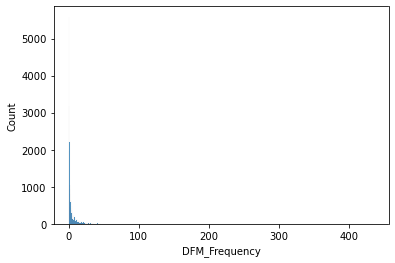

In [73]:
## plot a recency histogram
sns.histplot(data=listening_summary_df,x='DFM_Frequency')

#### 2.DETERMINE K

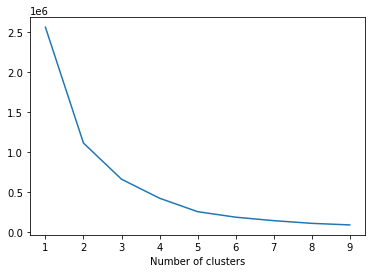

In [130]:
# ## Elbow Method to determine K

# sse = find_sse(listening_summary_df.loc[:,['DFM_Frequency']], max_k = 10) 

# plt.figure()
# plt.plot(list(sse.keys()),list(sse.values()))
# plt.xlabel("Number of clusters")
# plt.show() 

# # Optimal K=5

#### 3.CLUSTERING

In [131]:
# ## k-means = 5
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(listening_summary_df[['DFM_Frequency']])
# listening_summary_df['DFM_FrequencyCluster'] = kmeans.predict(listening_summary_df[['DFM_Frequency']])

# listening_summary_df = order_cluster('DFM_FrequencyCluster', 'DFM_Frequency',listening_summary_df,True)

# ## see details of each cluster
# listening_summary_df.groupby('DFM_FrequencyCluster')['DFM_Frequency'].describe()

# ## Frequency Cluster - số lần nghe/ 1 tuần


,count,mean,std,min,25%,50%,75%,max
DFM_FrequencyCluster,,,,,,,,
0,22399.0,1.473384,1.570671,0.038462,0.294118,0.875,2.040064,6.636364
1,3576.0,11.802424,3.976034,6.642857,8.333333,11.000,14.600000,21.210526
2,990.0,30.684228,7.261431,21.250000,24.600000,29.000,35.500000,49.714286
3,215.0,69.150140,18.374953,50.000000,55.666667,64.000,76.555556,162.000000
4,3.0,341.333333,89.790497,256.000000,294.500000,333.000,384.000000,435.000000


In [140]:
listening_summary_df.shape,dfm_user_df.shape

((27183, 10), (27458, 6))

In [208]:
# Ghi dữ liệu vào dfm_user_df
dfm_cols = ["User_ID","DFM_Duration_per_view","DFM_DurationCluster","DFM_week_cnt","DFM_Frequency","DFM_FrequencyCluster"]
dfm_user_df = dfm_user_df.join(listening_summary_df[dfm_cols].set_index("User_ID"),on="User_ID",how="outer")

### Monetary - the average of money users spend on listening for a week 

In [148]:
order_summary_df.head(3)

,User_ID,min_purchase_date,max_purchase_date,order_cnt,revenue
0,40843,2020-09-15,2020-10-21,3,27000
1,40861,2020-09-09,2020-09-09,1,199000
2,41003,2020-10-27,2020-10-27,1,599000


In [209]:
dfm_user_df = dfm_user_df.join(order_summary_df[['User_ID','revenue']].set_index('User_ID'),how='outer',on='User_ID')
dfm_user_df.head(3)

,User_ID,DFM_Duration_per_view,DFM_DurationCluster,DFM_week_cnt,DFM_Frequency,DFM_FrequencyCluster,revenue
0,40834,4.350000,0.0,26.0,0.076923,0.0,NaN
1,40844,6.226846,0.0,27.0,5.518519,0.0,NaN
2,40847,0.300000,0.0,26.0,0.153846,0.0,NaN


In [180]:
dfm_user_df[dfm_user_df["DFM_Duration_per_view"].isnull()].revenue.describe()

#275 users không nghe, có order

count    2.750000e+02
mean     1.784436e+05
std      2.089908e+05
min      9.000000e+03
25%      9.000000e+03
50%      1.490000e+05
75%      1.990000e+05
max      1.198000e+06
Name: revenue, dtype: float64

In [170]:
dfm_user_df[(dfm_user_df["DFM_Duration_per_view"]== 0.0) & (dfm_user_df['revenue'].isnull())].shape[0]

# 93 user ko nghe, ko order

93

In [163]:
dfm_user_df[dfm_user_df["DFM_Duration_per_view"]== 0.0].revenue

array([nan])

In [181]:
print("số lượng free users: "+str(dfm_user_df[dfm_user_df["revenue"].isnull()].shape[0]))
print("số lượng ordering users without listening: "+ str(dfm_user_df[dfm_user_df["DFM_Duration_per_view"].isnull()].shape[0]))

số lượng free users: 24820
số lượng ordering users without listening: 275


#### Xử lý dữ liệu NaN

In [210]:
# 1. DFM_Duration_per_view: NaN --> 0
dfm_user_df.loc[dfm_user_df["DFM_Duration_per_view"].isnull(),["DFM_Duration_per_view"]] = 0.0
dfm_user_df[dfm_user_df["DFM_Duration_per_view"]== 0.0].shape[0]

368

In [211]:
dfm_user_df[dfm_user_df["DFM_Frequency"].isnull()].shape[0],dfm_user_df[dfm_user_df["DFM_Frequency"] == 0.0].shape[0]

(275, 0)

In [212]:
# 2. DFM_Frequency : NaN -->0
dfm_user_df.loc[dfm_user_df["DFM_Frequency"].isnull(),["DFM_Frequency"]] = 0.0
dfm_user_df[dfm_user_df["DFM_Frequency"]== 0.0].shape[0]

275

#### 1. CALCULATE  the average of money paid for a week

In [ ]:
# 3. revenue:
## 1. revenue NaN --> DFM_Monetary = 0 : Nghe miễn phí
## 2. DFM_Duration_per_view == 0 & revenue != 0 --> DFM_Monetary = revenue : sẵn sàng trả tiền nhưng chưa nghe
## 3. DFM_Duration_per_view != 0 & revenue != 0 --> DFM_Monetary = revenue/week_cnt sẵn sàng trả tiền và có nghe

In [215]:
dfm_user_df.head(3)

,User_ID,DFM_Duration_per_view,DFM_DurationCluster,DFM_week_cnt,DFM_Frequency,DFM_FrequencyCluster,revenue
0,40834,4.350000,0.0,26.0,0.076923,0.0,0.0
1,40844,6.226846,0.0,27.0,5.518519,0.0,0.0
2,40847,0.300000,0.0,26.0,0.153846,0.0,0.0


In [204]:
def calculate_DFM_Monetary(row):
    val = 0.0
    if row['DFM_Duration_per_view'] == 0:
        val = row['revenue']
    else:
        val = float(row['revenue']/row['DFM_week_cnt'])
    return val

In [214]:
# đặt revenue bằng 0.0 cho free user
dfm_user_df.loc[dfm_user_df["revenue"].isnull(),["revenue"]]=0.0

#Tính DFM_Monetary cho user
dfm_user_df["DFM_Monetary"] = dfm_user_df.apply(calculate_DFM_Monetary,axis=1)

In [219]:
dfm_user_df["DFM_Monetary"].describe()

count    2.745800e+04
mean     5.807049e+03
std      3.591094e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.198000e+06
Name: DFM_Monetary, dtype: float64

In [218]:
dfm_user_df[dfm_user_df["DFM_Monetary"] == 0.0].shape[0]

24820

In [61]:
# Tính Monetaty value: money spending for a week
order_summary_df['DRM_Monetary'] = round(order_summary_df['revenue']/order_summary_df['DRM_order_week_cnt'],0)

In [62]:
order_summary_df['DRM_Monetary'].describe()

count       2638.000000
mean       58693.088704
std       102177.540113
min          375.000000
25%        10474.000000
50%        24875.000000
75%        56000.000000
max      1000000.000000
Name: DRM_Monetary, dtype: float64

<AxesSubplot:xlabel='DRM_Monetary', ylabel='Count'>

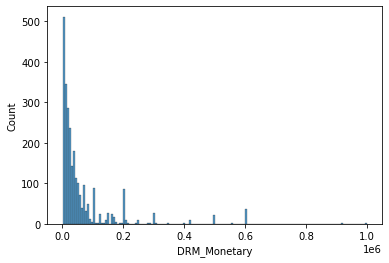

In [63]:
## plot a recency histogram
sns.histplot(data=order_summary_df,x='DRM_Monetary')

### DETERMINE K

### CLUSTERING